In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import seaborn as sns
import random
import implicit
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
%matplotlib inline
from graphlab import SFrame
from graphlab import model_parameter_search, SFrame
import graphlab as gl
import graphlab.aggregate as agg

import sys
reload(sys)
sys.setdefaultencoding('utf8')

In [2]:
gl.canvas.set_target('ipynb')

In [3]:
df=pd.read_excel('Online Retail.xlsx')
len(df)

541909

In [4]:
df = df.loc[pd.isnull(df.CustomerID) == False]
len(df)

406829

In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
item_lookup = df[['StockCode', 'Description']].drop_duplicates() 
# Only get unique item/description pairs

In [7]:
item_lookup['StockCode'] = item_lookup.StockCode.astype(str) 
# Encode as strings for future lookup ease

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [10]:
df['Items']= df['StockCode'].astype(str)+' : '+df['Description'].astype(str)
df.drop(["StockCode", "Description", "InvoiceDate", "Country"], axis=1, inplace=True)
df.head()

,InvoiceNo,Quantity,UnitPrice,CustomerID,Items
0,536365,6,2.55,17850.0,85123A : WHITE HANGING HEART T-LIGHT HOLDER
1,536365,6,3.39,17850.0,71053 : WHITE METAL LANTERN
2,536365,8,2.75,17850.0,84406B : CREAM CUPID HEARTS COAT HANGER
3,536365,6,3.39,17850.0,84029G : KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,6,3.39,17850.0,84029E : RED WOOLLY HOTTIE WHITE HEART.


In [11]:
df['CustomerID'] = df.CustomerID.astype(int) 
# Convert to int for customer ID

df = df[['Items', 'Quantity', 'CustomerID']] 
# Get rid of unnecessary info

df

,Items,Quantity,CustomerID
0,85123A : WHITE HANGING HEART T-LIGHT HOLDER,6,17850
1,71053 : WHITE METAL LANTERN,6,17850
2,84406B : CREAM CUPID HEARTS COAT HANGER,8,17850
3,84029G : KNITTED UNION FLAG HOT WATER BOTTLE,6,17850
4,84029E : RED WOOLLY HOTTIE WHITE HEART.,6,17850
5,22752 : SET 7 BABUSHKA NESTING BOXES,2,17850
6,21730 : GLASS STAR FROSTED T-LIGHT HOLDER,6,17850
7,22633 : HAND WARMER UNION JACK,6,17850
8,22632 : HAND WARMER RED POLKA DOT,6,17850
9,84879 : ASSORTED COLOUR BIRD ORNAMENT,32,13047


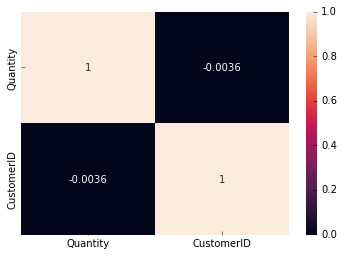

In [12]:
corr= df[df.columns].corr()
sns.heatmap(corr,annot=True);

In [13]:
df.isnull().sum()

Items         0
Quantity      0
CustomerID    0
dtype: int64

In [14]:
dfg = df.groupby(['CustomerID', 'Items']).sum().reset_index() 
# Group together

dfg.Quantity.loc[dfg.Quantity == 0] = 1 
# Replace a sum of zero purchases with a one to indicate purchased

dfg

C:\ProgramData\Anaconda2\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,CustomerID,Items,Quantity
0,12346,23166 : MEDIUM CERAMIC TOP STORAGE JAR,1
1,12347,16008 : SMALL FOLDING SCISSOR(POINTED EDGE),24
2,12347,17021 : NAMASTE SWAGAT INCENSE,36
3,12347,20665 : RED RETROSPOT PURSE,6
4,12347,20719 : WOODLAND CHARLOTTE BAG,40
5,12347,20780 : BLACK EAR MUFF HEADPHONES,12
6,12347,20782 : CAMOUFLAGE EAR MUFF HEADPHONES,6
7,12347,20966 : SANDWICH BATH SPONGE,10
8,12347,21035 : SET/2 RED RETROSPOT TEA TOWELS,6
9,12347,21041 : RED RETROSPOT OVEN GLOVE DOUBLE,12


In [15]:
dfgp = dfg.query('Quantity > 0') 
# Only get customers where purchase totals were positive

dfgp

,CustomerID,Items,Quantity
0,12346,23166 : MEDIUM CERAMIC TOP STORAGE JAR,1
1,12347,16008 : SMALL FOLDING SCISSOR(POINTED EDGE),24
2,12347,17021 : NAMASTE SWAGAT INCENSE,36
3,12347,20665 : RED RETROSPOT PURSE,6
4,12347,20719 : WOODLAND CHARLOTTE BAG,40
5,12347,20780 : BLACK EAR MUFF HEADPHONES,12
6,12347,20782 : CAMOUFLAGE EAR MUFF HEADPHONES,6
7,12347,20966 : SANDWICH BATH SPONGE,10
8,12347,21035 : SET/2 RED RETROSPOT TEA TOWELS,6
9,12347,21041 : RED RETROSPOT OVEN GLOVE DOUBLE,12


In [16]:
r = dfgp['Quantity'].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(r.reshape(-1,1))
df_normalized=pd.DataFrame(x_scaled)
dfgp['nQuantity'] = df_normalized

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


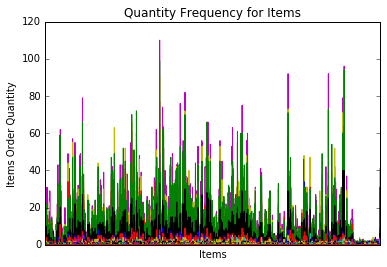

In [17]:
pd.crosstab(dfgp.Items,df.Quantity).plot()
plt.title('Quantity Frequency for Items')
plt.xlabel('Items')
plt.xticks([])
plt.ylabel('Items Order Quantity')
plt.gca().legend_.remove();

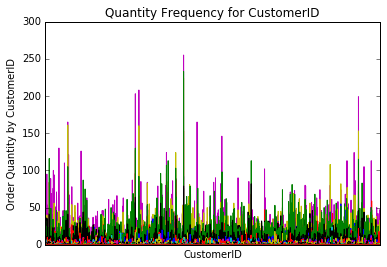

In [52]:
pd.crosstab(dfgp.CustomerID,df.Quantity).plot()
plt.title('Quantity Frequency for CustomerID')
plt.xlabel('CustomerID')
plt.xticks([])
plt.ylabel('Order Quantity by CustomerID')
plt.gca().legend_.remove();

In [19]:
dfgp.head()

,CustomerID,Items,Quantity,nQuantity
0,12346,23166 : MEDIUM CERAMIC TOP STORAGE JAR,1,0.000000
1,12347,16008 : SMALL FOLDING SCISSOR(POINTED EDGE),24,0.001834
2,12347,17021 : NAMASTE SWAGAT INCENSE,36,0.002791
3,12347,20665 : RED RETROSPOT PURSE,6,0.000399
4,12347,20719 : WOODLAND CHARLOTTE BAG,40,0.003110


In [20]:
customers = dfgp.CustomerID.nunique() 
# Get our unique customers

customers

4338

In [21]:
items = dfgp.Items.nunique() 
# Get our unique products that were purchased

items

3896

In [22]:
quantity = dfgp.Quantity 
# All of our purchases

quantity

0           1
1          24
2          36
3           6
4          40
5          12
6           6
7          10
8           6
9          12
10         30
11         10
12         12
13         24
14          6
15         12
16         72
17         48
18         12
19         48
20         48
21          6
22         12
23         48
24         72
25          6
26         12
27         32
28          8
29         16
         ... 
269240     12
269241      6
269242     12
269243     12
269244     48
269245     20
269246     48
269247     48
269248     48
269249     24
269250     36
269251     12
269252     12
269253     36
269254     48
269255     24
269256     20
269257     36
269258     48
269259     24
269260     60
269261     24
269262     24
269263      6
269264      6
269265      4
269266     96
269267    120
269268     48
269269     48
Name: Quantity, Length: 268324, dtype: int64

In [23]:
dfgp=dfgp.dropna(axis=0, how='any')

In [24]:
dfgp.describe()

,CustomerID,Quantity,nQuantity
count,267386.000000,267386.000000,267386.000000
mean,15269.680185,18.396259,0.001386
std,1702.785591,94.062490,0.007498
min,12346.000000,1.000000,0.000000
25%,13869.000000,2.000000,0.000080
50%,15211.000000,6.000000,0.000399
75%,16764.000000,12.000000,0.000877
max,18252.000000,12540.000000,1.000000


In [25]:
dfgp.dtypes

CustomerID      int64
Items          object
Quantity        int64
nQuantity     float64
dtype: object

In [26]:
dfgp['CustomerID']=dfgp['CustomerID'].astype(str)
dfgp['Items']=dfgp['Items'].astype(str)
dfgp['Quantity']=dfgp['Quantity'].astype(float)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [27]:
dfgp.groupby('Items').count()

,CustomerID,Quantity,nQuantity
Items,,,
10002 : INFLATABLE POLITICAL GLOBE,40,40,40
10080 : GROOVY CACTUS INFLATABLE,19,19,19
10120 : DOGGY RUBBER,25,25,25
10123C : HEARTS WRAPPING TAPE,3,3,3
10124A : SPOTS ON RED BOOKCOVER TAPE,5,5,5
10124G : ARMY CAMO BOOKCOVER TAPE,4,4,4
10125 : MINI FUNKY DESIGN TAPES,49,49,49
10133 : COLOURING PENCILS BROWN TUBE,100,100,100
10135 : COLOURING PENCILS BROWN TUBE,91,91,91


In [28]:
sf=SFrame(data=dfgp)
sf

This non-commercial license of GraphLab Create for academic use is assigned to patelsumitm@gmail.com and will expire on February 23, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\Timus\AppData\Local\Temp\graphlab_server_1524248400.log.0


CustomerID,Items,Quantity,nQuantity
12346,23166 : MEDIUM CERAMICTOP STORAGE JAR ...,1.0,0.0
12347,16008 : SMALL FOLDINGSCISSOR(POINTED EDGE) ...,24.0,0.00183427705559
12347,17021 : NAMASTE SWAGATINCENSE ...,36.0,0.00279129117154
12347,20665 : RED RETROSPOTPURSE ...,6.0,0.000398755881649
12347,20719 : WOODLANDCHARLOTTE BAG ...,40.0,0.00311029587686
12347,20780 : BLACK EAR MUFFHEADPHONES ...,12.0,0.000877262939628
12347,20782 : CAMOUFLAGE EARMUFF HEADPHONES ...,6.0,0.000398755881649
12347,20966 : SANDWICH BATHSPONGE ...,10.0,0.000717760586969
12347,21035 : SET/2 REDRETROSPOT TEA TOWELS ...,6.0,0.000398755881649
12347,21041 : RED RETROSPOTOVEN GLOVE DOUBLE ...,12.0,0.000877262939628


In [29]:
sf.dtype()

[str, str, float, float]

In [30]:
sf['Items']=sf['Items'].astype(str)
len(sf)

267386

In [31]:
sf=sf.dropna(how='all')
len(sf)

267386

In [32]:
data=sf.groupby(['CustomerID', 'Items'],operations={'totalquantity': agg.SUM('Quantity'), 'meanquantity': agg.AVG('Quantity'), 'stdquantity': agg.STD('Quantity')})
data['meanquantity']=data['meanquantity'].astype(float)
data['stdquantity']=data['stdquantity'].astype(float)
data['totalquantity']=data['totalquantity'].astype(float)
data.show

<bound method SFrame.show of Columns:
	CustomerID	str
	Items	str
	meanquantity	float
	totalquantity	float
	stdquantity	float

Rows: 267386

Data:
+------------+-------------------------------+--------------+---------------+
| CustomerID |             Items             | meanquantity | totalquantity |
+------------+-------------------------------+--------------+---------------+
|   15069    | 23112 : PARISIENNE CURIO C... |     2.0      |      2.0      |
|   16086    | 11001 : ASSTD DESIGN RACIN... |     48.0     |      48.0     |
|   18203    | 22096 : PINK PAISLEY SQUAR... |     3.0      |      3.0      |
|   17649    | 22908 : PACK OF 20 NAPKINS... |     12.0     |      12.0     |
|   12429    | 85159A : BLACK TEA,COFFEE,... |     12.0     |      12.0     |
|   12822    | 22417 : PACK OF 60 SPACEBO... |     24.0     |      24.0     |
|   16549    | 22529 : MAGIC DRAWING SLAT... |     3.0      |      3.0      |
|   12994    | 22138 : BAKING SET 9 PIECE... |     3.0      |      3.0    

In [33]:
data['zquantity']= ((data['totalquantity']-data['meanquantity']) / data['stdquantity'])
data['zquantity']=data['zquantity'].astype(float)
data

CustomerID,Items,meanquantity,totalquantity,stdquantity,zquantity
15069,23112 : PARISIENNE CURIOCABINET ...,2.0,2.0,0.0,nan
16086,11001 : ASSTD DESIGNRACING CAR PEN ...,48.0,48.0,0.0,nan
18203,22096 : PINK PAISLEYSQUARE TISSUE BOX ...,3.0,3.0,0.0,nan
17649,22908 : PACK OF 20NAPKINS RED APPLES ...,12.0,12.0,0.0,nan
12429,"85159A : BLACKTEA,COFFEE,SUGAR JARS ...",12.0,12.0,0.0,nan
12822,22417 : PACK OF 60SPACEBOY CAKE CASES ...,24.0,24.0,0.0,nan
16549,22529 : MAGIC DRAWINGSLATE GO TO THE FAIR ...,3.0,3.0,0.0,nan
12994,22138 : BAKING SET 9PIECE RETROSPOT ...,3.0,3.0,0.0,nan
15257,22771 : CLEAR DRAWER KNOBACRYLIC EDWARDIAN ...,24.0,24.0,0.0,nan
13799,22649 : STRAWBERRY FAIRYCAKE TEAPOT ...,8.0,8.0,0.0,nan


In [34]:
data['CustomerID'].unique()

dtype: str
Rows: 4316
['15258', '13895', '15668', '13525', '13148', '15721', '18242', '14320', '13802', '15994', '16057', '12865', '13279', '13394', '13969', '16899', '12736', '13066', '15067', '14944', '16441', '13959', '15415', '17095', '13065', '17957', '16203', '15949', '18123', '12951', '14794', '18027', '17956', '16732', '18081', '14001', '13501', '15024', '16449', '13639', '16929', '16491', '16764', '14731', '17221', '17564', '16162', '16006', '15701', '16045', '12357', '14609', '12574', '14851', '13601', '12552', '13221', '16531', '12974', '14474', '14293', '15472', '14191', '16211', '18150', '15874', '14005', '16542', '15178', '17447', '13882', '15119', '18229', '17353', '17747', '13080', '13122', '15249', '18251', '14056', '15063', '14439', '16626', '16511', '18085', '13011', '17163', '12843', '16566', '17372', '16904', '13991', '16755', '17100', '17514', '13823', '14973', '14407', '13723', '13255', ... ]

In [35]:
data['Items'].unique()

dtype: str
Rows: 3896
['21245 : GREEN POLKADOT PLATE ', '37450 : CERAMIC CAKE BOWL + HANGING CAKES', '22416 : SET OF 36 SPACEBOY PAPER DOILIES', '85089 : CANDY SPOT BUNNY', '82483 : WOOD 2 DRAWER CABINET WHITE FINISH', '23530 : WALL ART ONLY ONE PERSON ', '23475 : WOODLAND SMALL PINK FELT HEART', '90026A : GLASS BEAD HOOP NECKLACE BLACK', '22135 : LADLE LOVE HEART PINK', '16049 : TEATIME GEL PENS ASST', '90081C : LILY BROOCH OLIVE COLOUR', '23263 : SET OF 3 WOODEN HEART DECORATIONS', '23388 : WOODLAND MINI BACKPACK', '84970L : SINGLE HEART ZINC T-LIGHT HOLDER', '21758 : VINTAGE SHELLS PRINT', '23691 : WRAP KEEP CALM BIRTHDAY', '23294 : SET OF 6 SNACK LOAF BAKING CASES', '21109 : LARGE CAKE TOWEL, CHOCOLATE SPOTS', '22959 : WRAP CHRISTMAS VILLAGE', '23045 : PAPER LANTERN 5 POINT STAR MOON ', '22690 : DOORMAT HOME SWEET HOME BLUE ', '22754 : SMALL RED BABUSHKA NOTEBOOK ', '23403 : LETTER HOLDER HOME SWEET HOME', '23575 : SNACK TRAY PAISLEY PARK', '23236 : STORAGE TIN VINTAGE DOILY ', '85

In [36]:
data['CustomerID'].show()

In [37]:
data['Items'].show()

In [38]:
users= data['CustomerID'].unique()
users.show()
items= data['Items'].unique()
items.show()

In [39]:
data['CustomerID','Items'].show()

In [40]:
ndata=sf['CustomerID','Items','nQuantity']
ndata

CustomerID,Items,nQuantity
12346,23166 : MEDIUM CERAMICTOP STORAGE JAR ...,0.0
12347,16008 : SMALL FOLDINGSCISSOR(POINTED EDGE) ...,0.00183427705559
12347,17021 : NAMASTE SWAGATINCENSE ...,0.00279129117154
12347,20665 : RED RETROSPOTPURSE ...,0.000398755881649
12347,20719 : WOODLANDCHARLOTTE BAG ...,0.00311029587686
12347,20780 : BLACK EAR MUFFHEADPHONES ...,0.000877262939628
12347,20782 : CAMOUFLAGE EARMUFF HEADPHONES ...,0.000398755881649
12347,20966 : SANDWICH BATHSPONGE ...,0.000717760586969
12347,21035 : SET/2 REDRETROSPOT TEA TOWELS ...,0.000398755881649
12347,21041 : RED RETROSPOTOVEN GLOVE DOUBLE ...,0.000877262939628


In [41]:
nis= gl.item_similarity_recommender.create(ndata,
                                                user_id='CustomerID',
                                                item_id='Items',
                                                target='nQuantity')

Recsys training: model = item_similarity

Preparing data set.

Data has 267386 observations with 4316 users and 3896 items.

Data prepared in: 0.210072s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.864ms                        | 23         |

| 9.388ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 71.504ms                            | 0                | 0               |

| 254.498ms                           | 100              | 3896            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.27592s

In [42]:
nrf = gl.ranking_factorization_recommender.create(ndata,
                                                             user_id='CustomerID',
                                                             item_id='Items',
                                                             target='nQuantity')

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 267386 observations with 4316 users and 3896 items.

Data prepared in: 0.201048s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 33423 / 267386 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | 9.39002e-005                             |

| 4       | 0.195312          | 8.83515e-005                             |

| 5       | 0.0976562         | 8.45582e-005                             |

| 6       | 0.0488281         | 8.51033e-005                             |

| 7       | 0.0244141         | 8.73343e-005                             |

| 8       | 0.012207          | 9.06134e-005                             |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 8.45582e-005                             |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 0.000112623       | 0.0075091             |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 122.311ms    | 0.000109267       | 0.00838793            | 0.0976562   |

| 2       | 218.567ms    | 0.000102341       | 0.00812287            | 0.0580668   |

| 3       | 313.82ms     | 0.000100468       | 0.00799033            | 0.042841    |

| 4       | 415.09ms     | 9.88319e-005      | 0.00790991            | 0.0345267   |

| 5       | 520.37ms     | 9.78565e-005      | 0.00786725            | 0.029206    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 9.69662e-005

Final training RMSE: 0.0077297

In [44]:
nm=gl.recommender.create(ndata, user_id='CustomerID', item_id='Items', target='nQuantity', ranking='True')
nm.show()

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 267386 observations with 4316 users and 3896 items.

Data prepared in: 0.240672s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-009   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-009   |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 33423 / 267386 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | 0.000109376                              |

| 4       | 0.195312          | 9.50666e-005                             |

| 5       | 0.0976562         | 9.14747e-005                             |

| 6       | 0.0488281         | 9.05187e-005                             |

| 7       | 0.0244141         | 9.11952e-005                             |

| 8       | 0.012207          | 9.28678e-005                             |

| 9       | 0.00610352        | 9.566e-005                               |

+---------+-------------------+------------------------------------------+

| Final   | 0.0488281         | 9.05187e-005                             |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 0.000112593       | 0.00750992            |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 136.363ms    | 0.000101471       | 0.0079658             | 0.0488281   |

| 2       | 261.696ms    | 9.81018e-005      | 0.00790424            | 0.0290334   |

| 3       | 382.517ms    | 9.66557e-005      | 0.00779897            | 0.0214205   |

| 4       | 485.791ms    | 9.61017e-005      | 0.00777547            | 0.0172633   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Convergence on objective within bounds.

Computing final objective value and training RMSE.

Final objective value: 9.52775e-005

Final training RMSE: 0.00772306

In [45]:
nm.evaluate_rmse(dataset=ndata, target='nQuantity')

{'rmse_by_item': Columns:
 	Items	str
 	count	int
 	rmse	float
 
 Rows: 3896
 
 Data:
 +-------------------------------+-------+------------------+
 |             Items             | count |       rmse       |
 +-------------------------------+-------+------------------+
 | 21245 : GREEN POLKADOT PLATE  |   72  | 0.00334889775892 |
 | 37450 : CERAMIC CAKE BOWL ... |   47  | 0.0036247911145  |
 | 22416 : SET OF 36 SPACEBOY... |   7   | 0.00499558870509 |
 |    85089 : CANDY SPOT BUNNY   |   5   | 0.00403099742942 |
 | 82483 : WOOD 2 DRAWER CABI... |  241  | 0.00435855557697 |
 | 23530 : WALL ART ONLY ONE ... |   59  | 0.00416345980276 |
 | 23475 : WOODLAND SMALL PIN... |   25  | 0.00380802373636 |
 | 90026A : GLASS BEAD HOOP N... |   1   | 0.00387956887552 |
 | 22135 : LADLE LOVE HEART PINK |   3   | 0.00527460220865 |
 | 16049 : TEATIME GEL PENS ASST |   5   | 0.00327886350768 |
 +-------------------------------+-------+------------------+
 [3896 rows x 3 columns]
 Note: Only the head 

In [46]:
recs=nm.recommend(users,k=20)

recommendations finished on 1000/4316 queries. users per second: 43363.3

recommendations finished on 2000/4316 queries. users per second: 48651.1

recommendations finished on 3000/4316 queries. users per second: 46031.3

recommendations finished on 4000/4316 queries. users per second: 48064.8

In [47]:
train, test = gl.recommender.util.random_split_by_user(ndata,
                                                             user_id='CustomerID',
                                                             item_id='Items')

In [48]:
factorization_nm = gl.recommender.factorization_recommender.create(train,user_id='CustomerID',item_id='Items',target='nQuantity', solver='als')

rfactorization_nm= gl.recommender.ranking_factorization_recommender.create(train,target='nQuantity', user_id='CustomerID',item_id='Items', solver='ials')

popularity_nm=gl.recommender.popularity_recommender.create(train,user_id='CustomerID',item_id='Items',target='nQuantity')

itemsimilarity_nm=gl.recommender.item_similarity_recommender.create(train,user_id='CustomerID',item_id='Items',target='nQuantity')

Recsys training: model = factorization_recommender

Preparing data set.

Data has 255626 observations with 4310 users and 3891 items.

Data prepared in: 0.1775s

Training factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 8        |

| regularization               | L2 Regularization on Factors                     | 1e-008   |

| max_iterations               | Maximum Number of Iterations                     | 50       |

| solver                       | Solver used for training                         | als      |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+------------------------+

| Iter.   | Elapsed time | RMSE                   |

+---------+--------------+------------------------+

| Initial | 0us          | NA                     |

+---------+--------------+------------------------+

| 0       | 76.203ms     | 0.0038467              |

| 1       | 137.364ms    | 0.00265305             |

| 2       | 190.506ms    | 0.00244247             |

| 3       | 245.652ms    | 0.00234564             |

| 4       | 300.799ms    | 0.00228559             |

| 5       | 347.924ms    | 0.00224209             |

| 6       | 406.079ms    | 0.00220791             |

| 7       | 460.223ms    | 0.00217973             |

| 8       | 517.375ms    | 0.00215607             |

| 9       | 568.513ms    | 0.00213568             |

| 10      | 626.666ms    | 0.00211782             |

| 11      | 671.786ms    | 0.00210211             |

| 12      | 726.933ms    | 0.00208825             |

| 13      | 778.069ms    | 0.00207591             |

| 14      | 827.199ms    | 0.00206489             |

| 15      | 880.341ms    | 0.00205499             |

| 16      | 941.504ms    | 0.00204597             |

| 17      | 992.641ms    | 0.00203766             |

| 18      | 1.03s        | 0.00202994             |

| 19      | 1.09s        | 0.00202275             |

| 20      | 1.16s        | 0.00201616             |

| 21      | 1.21s        | 0.0020101              |

| 22      | 1.27s        | 0.00200448             |

| 23      | 1.33s        | 0.0019992              |

| 24      | 1.40s        | 0.00199425             |

| 25      | 1.44s        | 0.00198966             |

| 26      | 1.50s        | 0.00198544             |

| 27      | 1.56s        | 0.00198151             |

| 28      | 1.60s        | 0.00197783             |

| 29      | 1.66s        | 0.00197434             |

| 30      | 1.71s        | 0.00197101             |

| 31      | 1.76s        | 0.00196782             |

| 32      | 1.82s        | 0.00196475             |

| 33      | 1.87s        | 0.00196181             |

| 34      | 1.92s        | 0.00195902             |

| 35      | 1.98s        | 0.00195637             |

| 36      | 2.03s        | 0.00195384             |

| 37      | 2.10s        | 0.00195143             |

| 38      | 2.16s        | 0.00194912             |

| 39      | 2.22s        | 0.00194691             |

| 40      | 2.29s        | 0.0019448              |

| 41      | 2.35s        | 0.00194278             |

| 42      | 2.41s        | 0.00194083             |

| 43      | 2.47s        | 0.00193894             |

| 44      | 2.52s        | 0.00193711             |

| 45      | 2.58s        | 0.00193534             |

| 46      | 2.64s        | 0.00193361             |

| 47      | 2.70s        | 0.00193194             |

| 48      | 2.76s        | 0.00193032             |

| 49      | 2.81s        | 0.00192874             |

| FINAL   | 2.81s        | 0.00192874             |

+---------+--------------+------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = ranking_factorization_recommender

Preparing data set.

Data has 255626 observations with 4310 users and 3891 items.

Data prepared in: 0.213568s

Training ranking_factorization_recommender for recommendations.

+------------------------------+--------------------------------------------------+----------+

| Parameter                    | Description                                      | Value    |

+------------------------------+--------------------------------------------------+----------+

| num_factors                  | Factor Dimension                                 | 32       |

| regularization               | L2 Regularization on Factors                     | 1e-009   |

| max_iterations               | Maximum Number of Iterations                     | 25       |

| solver                       | Solver used for training                         | ials     |

+------------------------------+--------------------------------------------------+----------+

+---------+--------------+---------------------------+

| Iter.   | Elapsed time | Estimated Objective Value |

+---------+--------------+---------------------------+

| Initial | 0us          | NA                        |

+---------+--------------+---------------------------+

| 0       | 146.387ms    | 0.191221                  |

| 1       | 276.734ms    | 0.321519                  |

| 2       | 409.086ms    | 0.34449                   |

| 3       | 546.452ms    | 0.352264                  |

| 4       | 674.793ms    | 0.355736                  |

| 5       | 815.166ms    | 0.357527                  |

| 6       | 942.505ms    | 0.358529                  |

| 7       | 1.09s        | 0.359132                  |

| 8       | 1.24s        | 0.359521                  |

| 9       | 1.37s        | 0.359788                  |

| 10      | 1.52s        | 0.359979                  |

| 11      | 1.65s        | 0.36012                   |

| 12      | 1.78s        | 0.360226                  |

| 13      | 1.94s        | 0.360307                  |

| 14      | 2.12s        | 0.36037                   |

| 15      | 2.31s        | 0.360419                  |

| 16      | 2.49s        | 0.360459                  |

| 17      | 2.68s        | 0.360491                  |

| 18      | 2.86s        | 0.360518                  |

| 19      | 3.05s        | 0.360541                  |

| 20      | 3.22s        | 0.360561                  |

| 21      | 3.37s        | 0.360579                  |

| 22      | 3.53s        | 0.360595                  |

| 23      | 3.70s        | 0.360611                  |

| 24      | 3.85s        | 0.360625                  |

| FINAL   | 3.85s        | 0.360625                  |

+---------+--------------+---------------------------+

Optimization Complete: Iteration limit reached.

Recsys training: model = popularity

Preparing data set.

Data has 255626 observations with 4310 users and 3891 items.

Data prepared in: 0.234626s

255626 observations to process; with 3891 unique items.

Recsys training: model = item_similarity

Preparing data set.

Data has 255626 observations with 4310 users and 3891 items.

Data prepared in: 0.179505s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 975us                          | 23         |

| 2.98ms                         | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 27.078ms                            | 0                | 0               |

| 280.719ms                           | 100              | 3891            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.293754s

In [49]:
factorization_nm.evaluate_rmse(dataset=ndata,target='nQuantity')
rfactorization_nm.evaluate_rmse(dataset=ndata,target='nQuantity')
popularity_nm.evaluate_rmse(dataset=ndata,target='nQuantity')
itemsimilarity_nm.evaluate_rmse(dataset=ndata,target='nQuantity')

{'rmse_by_item': Columns:
 	Items	str
 	count	int
 	rmse	float
 
 Rows: 3896
 
 Data:
 +-------------------------------+-------+------------------+
 |             Items             | count |       rmse       |
 +-------------------------------+-------+------------------+
 | 21245 : GREEN POLKADOT PLATE  |   72  |  0.035735330169  |
 | 37450 : CERAMIC CAKE BOWL ... |   47  | 0.0250495032523  |
 | 22416 : SET OF 36 SPACEBOY... |   7   | 0.00281145496221 |
 |    85089 : CANDY SPOT BUNNY   |   5   | 0.00623203463655 |
 | 82483 : WOOD 2 DRAWER CABI... |  241  | 0.0197993845537  |
 | 23530 : WALL ART ONLY ONE ... |   59  | 0.00789058343815 |
 | 23475 : WOODLAND SMALL PIN... |   25  | 0.0132926584821  |
 | 90026A : GLASS BEAD HOOP N... |   1   |  0.149239590867  |
 | 22135 : LADLE LOVE HEART PINK |   3   | 0.00529953478849 |
 | 16049 : TEATIME GEL PENS ASST |   5   |  0.001653879991  |
 +-------------------------------+-------+------------------+
 [3896 rows x 3 columns]
 Note: Only the head 

In [50]:
#Get recommendations for first 5 users and print them
#users = range(1,6) specifies user ID of first 5 users
#k=5 specifies top 5 recommendations to be given
factorizationevalnm = factorization_nm.recommend(users=range(1,6),k=5)
factorizationevalnm.print_rows(num_rows=25)

rfactorizationevalnm = rfactorization_nm.recommend(users=range(1,6),k=5)
rfactorizationevalnm.print_rows(num_rows=25)

popularityevalnm = popularity_nm.recommend(users=range(1,6),k=5)
popularityevalnm.print_rows(num_rows=25)

itemsimilarityevalnm = itemsimilarity_nm.recommend(users=range(1,6),k=5)
itemsimilarityevalnm.print_rows(num_rows=25)

+------------+--------------------------------+------------------+------+
| CustomerID |             Items              |      score       | rank |
+------------+--------------------------------+------------------+------+
|     1      | 20719 : WOODLAND CHARLOTTE BAG | 0.00137723198865 |  1   |
|     1      |  20665 : RED RETROSPOT PURSE   | 0.00137723198865 |  2   |
|     1      | 17021 : NAMASTE SWAGAT INCENSE | 0.00137723198865 |  3   |
|     1      | 16008 : SMALL FOLDING SCIS...  | 0.00137723198865 |  4   |
|     1      | 23166 : MEDIUM CERAMIC TOP...  | 0.00137723198865 |  5   |
|     2      | 20719 : WOODLAND CHARLOTTE BAG | 0.00137723198865 |  1   |
|     2      |  20665 : RED RETROSPOT PURSE   | 0.00137723198865 |  2   |
|     2      | 17021 : NAMASTE SWAGAT INCENSE | 0.00137723198865 |  3   |
|     2      | 16008 : SMALL FOLDING SCIS...  | 0.00137723198865 |  4   |
|     2      | 23166 : MEDIUM CERAMIC TOP...  | 0.00137723198865 |  5   |
|     3      | 20719 : WOODLAND CHARLO

In [51]:
model_compare_nm= gl.compare(test2, [nm, factorization_nm,rfactorization_nm,popularity_nm,itemsimilarity_nm])

NameError: name 'test2' is not defined

In [ ]:
model_compare_nm.show